In [1]:
import glob
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
data_dir = 'data_meg'
subj = "R2210"
dtype = "raw"
raw = mne.io.read_raw_fif('data_meg/R2210_raw_ica.fif', preload=True)
save_dir = 'data_meg'

Opening raw data file data_meg/R2210_raw_ica.fif...


/var/folders/4s/v49tr3_d3vn5jcm7fg7z3cv00000gp/T/ipykernel_61515/4196179896.py:11: RuntimeWarning: This filename (data_meg/R2210_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('data_meg/R2210_raw_ica.fif', preload=True)


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/labadmin/meg_decoding/data_meg/R2210_raw_ica-1.fif...
    Range : 2780000 ... 2954999 =   2780.000 ...  2954.999 secs
Ready.
Reading 0 ... 2954999  =      0.000 ...  2954.999 secs...


In [2]:
raw.filter(1, 40, method='iir')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



<Raw | R2210_raw_ica.fif, 193 x 2955000 (2955.0 s), ~4.25 GB, data loaded>

In [2]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 1,
    'move': 2,
    'reveal_red': 4,
    'reveal_white': 8,
    'done': 16,
}


5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]


In [3]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Initialize a list to store trial information
trial_info = []

done_idx = 0

for start_event in start_events:
    start_sample = start_event[0]
    
    # Find the corresponding 'done' event
    while done_idx < len(done_events) and done_events[done_idx, 0] <= start_sample:
        done_idx += 1
    if done_idx < len(done_events):
        done_sample = done_events[done_idx, 0]
        done_idx += 1

        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = (done_sample - start_sample) / sfreq + 1.0  # Duration from 'start' to 1 s after 'done'

        # Store trial information
        trial_info.append({
            'event_sample': start_sample,
            'tmin': tmin,
            'tmax': tmax
        })
max_tmax = max([info['tmax'] for info in trial_info])
print(f"Maximum epoch duration: {max_tmax:.2f} seconds")


Maximum epoch duration: 78.10 seconds


In [4]:
new_events = np.array([[info['event_sample'], 0, event_id['start']] for info in trial_info])
tmin = -0.2  

In [6]:
# Initialize lists to store individual epochs data and trial information
epochs_data_list = []
trial_info_valid = []

for idx, event in enumerate(new_events):
    start_sample = event[0]
    event_id_code = event[2]

    # Determine available duration based on the next event or end of recording
    if idx < len(start_events) - 1:
        end_sample = start_events[idx + 1][0]  # Use the next event to determine end
    else:
        end_sample = len(raw.times)  # Use the end of recording

    # Calculate available tmax
    available_duration = (end_sample - start_sample) / sfreq
    actual_tmax = min(max_tmax, available_duration - tmin)

    # Create a shorter epoch if required
    if actual_tmax > 0:
        # Create an epoch individually for each event
        epochs = mne.Epochs(raw, [event], event_id={f'event_{event_id_code}': event_id_code},
                            tmin=tmin, tmax=actual_tmax, baseline=(None, 0), preload=True, 
                            reject_by_annotation=False, reject=None)
        if len(epochs) > 0:
            epochs_data_list.append(epochs.get_data())
            trial_info_valid.append(trial_info[idx])

# Create a unified masked data structure with variable lengths
max_channels = raw.info['nchan']
masked_data_list = []

for data, info in zip(epochs_data_list, trial_info_valid):
    # Extract shape
    n_channels, n_times = data.shape[1], data.shape[2]

    # Create a valid data mask
    valid_data_mask = np.zeros((n_channels, n_times), dtype=bool)
    duration_samples = int((info['tmax'] - tmin) * sfreq)
    valid_data_mask[:, :duration_samples] = True

    # Create masked array for the epoch
    masked_epoch_data = ma.masked_array(data[0], mask=~valid_data_mask)
    masked_data_list.append(masked_epoch_data)

# Print information about the created epochs
print(f"Number of trials in trial_info_valid: {len(trial_info_valid)}")
print(f"Number of epochs after handling short recordings: {len(masked_data_list)}")

# Example usage: iterate over masked data for further analysis
for idx, masked_data in enumerate(masked_data_list):
    print(f"Epoch {idx + 1}: Shape = {masked_data.shape}, Masked = {masked_data.mask.sum()} points")


Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 30219 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 39581 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 20777 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 57118 original time 

/var/folders/4s/v49tr3_d3vn5jcm7fg7z3cv00000gp/T/ipykernel_61515/2709811883.py:22: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(raw, [event], event_id={f'event_{event_id_code}': event_id_code},


In [7]:
# Step 1: Determine the maximum length across all epochs
max_times = max([masked_data.shape[2] for masked_data in epochs_data_list])

# Step 2: Create arrays to store padded epoch data and corresponding masks
n_epochs = len(epochs_data_list)
n_channels = raw.info['nchan']

# Initialize the padded epochs data array with NaNs
epochs_array = np.full((n_epochs, n_channels, max_times), np.nan)

# Initialize the mask array with False (will set to True for padded values)
mask_array = np.zeros((n_epochs, n_channels, max_times), dtype=bool)

# Step 3: Fill the data and create the mask for each epoch
for idx, (data, info) in enumerate(zip(epochs_data_list, trial_info_valid)):
    n_times = data.shape[2]
    # Fill the epochs array with the actual data
    epochs_array[idx, :, :n_times] = data[0]
    
    # Set the mask to True for the padded values
    mask_array[idx, :, n_times:] = True

# Step 4: Create a masked array using the data and the mask
masked_data_array = ma.masked_array(epochs_array, mask=mask_array)



In [9]:
np.savez('epochs_data.npz', epochs=epochs_array, mask=mask_array)

Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 78303 original time points ...
3 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using matplotlib as 2D backend.


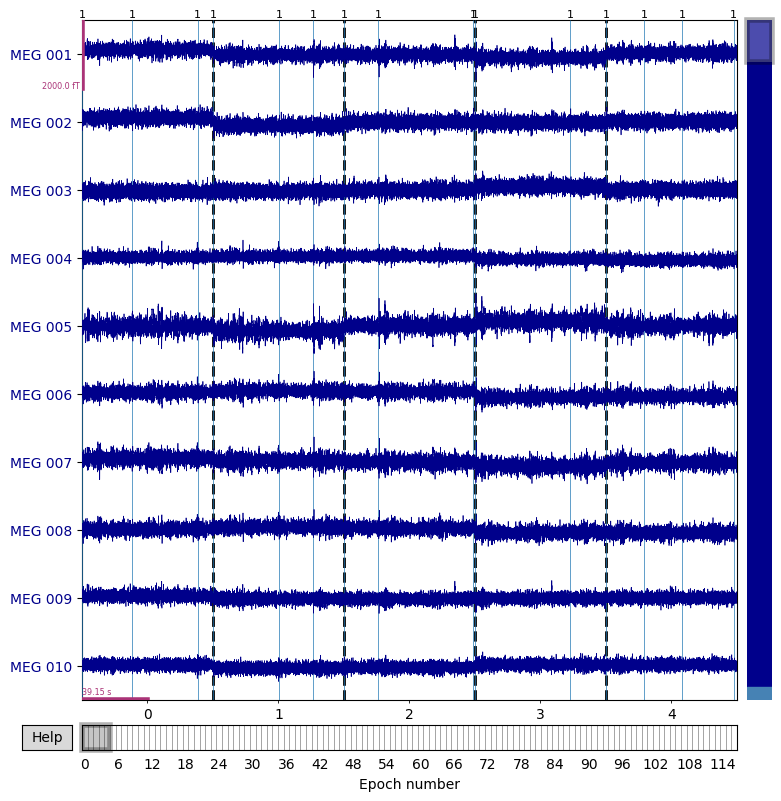

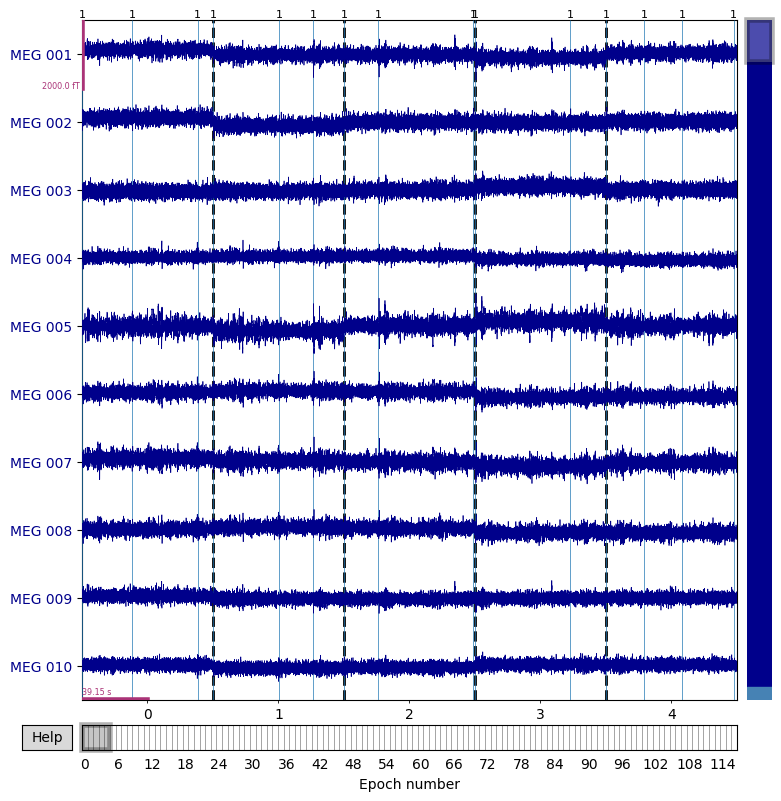

In [5]:
# Create epochs without rejecting short epochs or based on any amplitude criteria
epochs = mne.Epochs(raw, new_events, event_id={'start': event_id['start']},
                    tmin=tmin, tmax=max_tmax, baseline=(None, 0),
                    preload=True, reject_by_annotation=False, reject=None)

epochs.plot(n_epochs=5, n_channels=10,events=True)


In [ ]:
meg_data = epochs.get_data(picks=["mag", "grad"])